In [8]:
import ast
import enum
import os
import pickle
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import src.python.yalefaces as yalefaces

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn import metrics

np.random.seed(15)

## Data preprocessing

### Load dataset

In [2]:
X, y = yalefaces.load("datasets/yalefaces", flatten=False)

### Plot dataset

<Figure size 432x288 with 0 Axes>

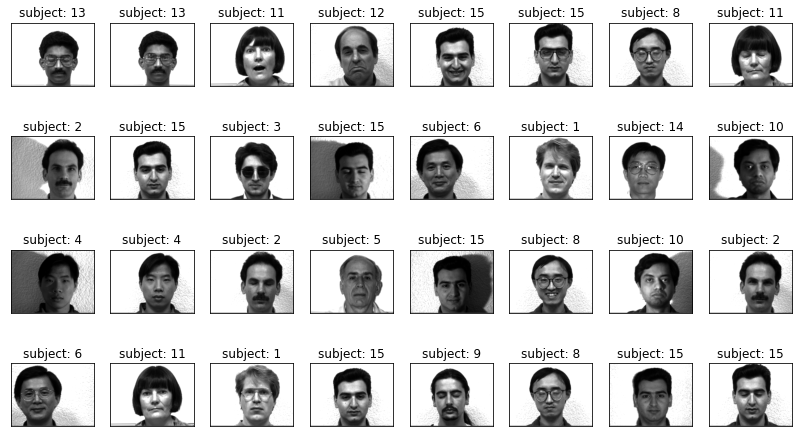

In [3]:
num_faces, num_pixels = X.shape

plt.figure()
f, axes = plt.subplots(4,8, figsize=(14, 8), sharey=True)

for ax in axes:
    for axy in ax:
        # select a random face
        face = np.random.randint(0, num_faces)
        
        # format image and label as in the raw dataset
        face_img = X[face].reshape(yalefaces.SHAPE)
        face_label = y[face] + 1

        # plot face
        axy.imshow(face_img, cmap='gray')
        
        # show only relevant information
        axy.set_title(f"subject: {face_label}")
        axy.set_xticks([])
        axy.set_yticks([])
plt.show()

### Identify most relevant pixels

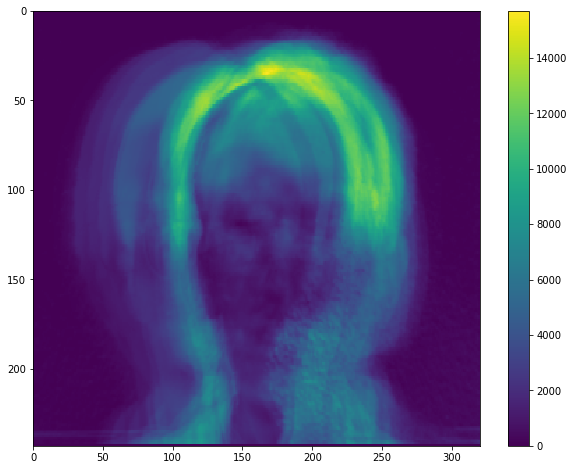

In [4]:
from sklearn.feature_selection import chi2

score, _ = chi2(X, y)
score_img = (np.array(score)).reshape(yalefaces.SHAPE)

plt.figure(figsize=(10, 8))

colormesh = plt.pcolormesh(score_img)
plt.colorbar(colormesh)

# mirror the y-axis because pcolormesh doesn't
# do this trick automatically as imgshow does.
plt.gca().invert_yaxis()
plt.show()

## Reduce number of dimensions

### Plot explained variance ratio

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

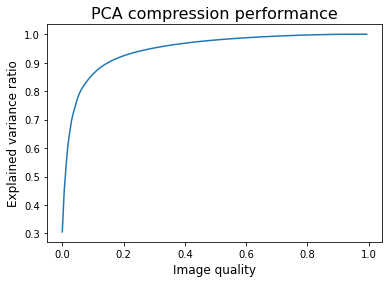

In [6]:
plt.plot(np.arange(num_faces)/165, np.cumsum(pca.explained_variance_ratio_))

plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Image quality", size=12)

plt.show()

### Choose image quality and compress images with PCA

In [7]:
image_quality = 1
n_components = int(num_faces * image_quality)

pca = PCA(n_components=n_components)
pca.fit(X)
X_compressed = pca.transform(X)
X_reconstructed = pca.inverse_transform(X_compressed)

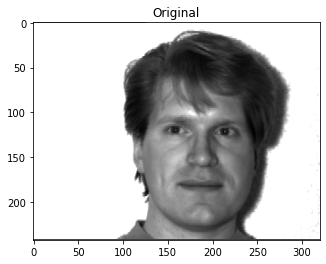

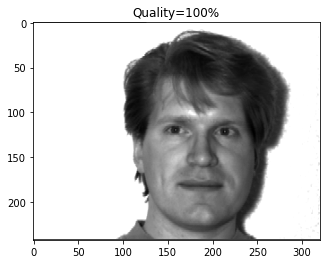

In [8]:
plt.imshow(X[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title("Original")
plt.show()

plt.imshow(X_reconstructed[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title(f"Quality={image_quality*100}%")
plt.show()

### Prepare datasets (original and compressed)

In [16]:
from sklearn.model_selection import train_test_split

# original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# compressed
X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

### Functions to store results

In [156]:
class ClassifierType(enum.Enum):
    LR = 1
    KNN = 2
    NN = 3
    CNN = 4

BEST_MODEL_NAME= 'model'
BEST_RESULT_NAME= 'best_result.csv'
PREDICTIONS_NAME = 'predictions.csv' 
PREDICTIONS_PROB_NAME =  'predictions_prob.csv'
RESULT_DIR_PATH = "results"

ORIGINAL_LABEL = 'original'
COMPRESSED_LABEL = 'compressed'

class ResultFileManagement:

    def __init__(self, classifier_type, dataset_label):
        self.classifier_type = classifier_type
        self.dataset_label = dataset_label

    def write_best_result(self, best_params, best_score):
        df = pd.DataFrame({'best_params': [str(best_params)], 'best_score': [str(best_score)]})
        self.create_dir()  
        df.to_csv(self.full_file_name(BEST_RESULT_NAME), index=False)

    def read_best_params(self):
        df_ = pd.read_csv(self.full_file_name(BEST_RESULT_NAME))
        ast.literal_eval(df_['best_params'].iloc[0])

    def read_best_score(self):
        df_ = pd.read_csv(self.full_file_name(BEST_RESULT_NAME))
        ast.literal_eval(df_['best_score'].iloc[0])

    def write_model(self, model):
        self.create_dir()
        model_pickle = open(self.full_file_name(BEST_MODEL_NAME), 'wb')
        pickle.dump(model, model_pickle)  
    
    def read_model(self):
        return pickle.load(open(self.full_file_name(BEST_MODEL_NAME), 'rb'))

    def result_exist(self):
        return os.path.exists(self.full_file_name(BEST_RESULT_NAME))

    def model_exist(self):
        return os.path.exists(self.full_file_name(BEST_MODEL_NAME))

    def full_file_name(self, sufix):
        return os.path.join(RESULT_DIR_PATH, f'{self.classifier_type.name}_{self.dataset_label}_{sufix}')
    
    def create_dir(self):
        if not os.path.exists(RESULT_DIR_PATH):
            os.mkdir(RESULT_DIR_PATH)


## Logistic Regression

In [157]:
def logistic_regression(X, y, dataset_label):
    result_mgt =ResultFileManagement(ClassifierType.LR, dataset_label)

    lr_classifier = None

    if(result_mgt.model_exist()):
        lr_classifier = result_mgt.read_model()
    else:
        lr_param_grid = [
            {
                'C':[1e-1, 1],
                #'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                #'solver': ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga'],
                #'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                'max_iter':[7600]
            }
        ]
        lr_grid_search = GridSearchCV(estimator = LogisticRegression(), 
            param_grid = lr_param_grid, scoring = 'accuracy', cv = KFold(n_splits=5), return_train_score=True)

        lr_classifier = lr_grid_search.fit(X, y)

        result_mgt.write_model(lr_classifier)
        result_mgt.write_best_result(lr_grid_search.best_params_, lr_grid_search.best_score_)

    return lr_classifier

### Train and test on the original dataset

In [158]:
lr_classifier = logistic_regression(X_train, y_train, ORIGINAL_LABEL)

Score (original): 0.92
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      0.75      0.75         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       0.80      1.00      0.89         4
          13       1.00      0.67      0.80         3
          14       0.75      1.00      0.86         3

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
wei

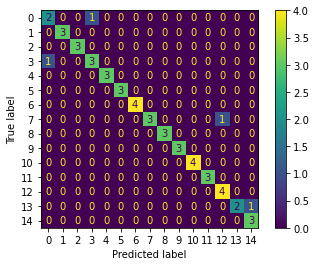

In [159]:
print("Score (original):", lr_classifier.score(X_test, y_test))

lr_pred = lr_classifier.predict(X_test)
print(metrics.classification_report(y_test, lr_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)

### Train and test on the compressed dataset

In [170]:
lr_classifier_compressed = logistic_regression(X_train_compressed, y_train_compressed, COMPRESSED_LABEL)

Score (compressed): 0.92
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      0.75      0.86         4
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       0.80      1.00      0.89         4
          13       1.00      1.00      1.00         3
          14       0.75      1.00      0.86         3

    accuracy                           0.92        50
   macro avg       0.94      0.92      0.92        50
w

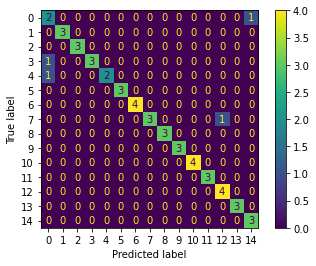

In [171]:
print("Score (compressed):", lr_classifier_compressed.score(X_test_compressed, y_test_compressed))

lr_pred_compressed = lr_classifier_compressed.predict(X_test_compressed)
print(metrics.classification_report(y_test_compressed, lr_pred_compressed))
ConfusionMatrixDisplay.from_predictions(y_test_compressed, lr_pred_compressed)

## KNN

### Train and test on the original dataset

In [162]:
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

Score (original): 0.8


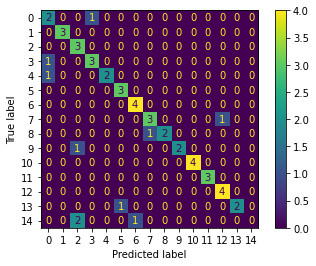

In [163]:
print("Score (original):", knn_classifier.score(X_test, y_test))

knn_pred = knn_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

### Train and test on the compressed dataset

In [164]:
knn_classifier_compressed = KNeighborsClassifier(n_neighbors=2)
knn_classifier_compressed.fit(X_train_compressed, y_train_compressed)

KNeighborsClassifier(n_neighbors=2)

Score (compressed): 0.8


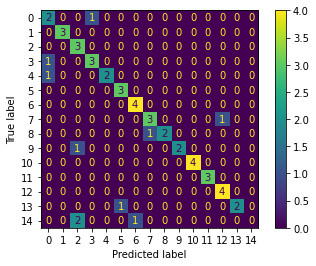

In [165]:
print("Score (compressed):", knn_classifier_compressed.score(X_test_compressed, y_test_compressed))

knn_pred_compressed = knn_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, knn_pred_compressed)

## Neural Networks

### Train and test on the original dataset

In [166]:
mlp_classifier = MLPClassifier(solver='adam', learning_rate_init=0.001, random_state=1)
mlp_classifier.fit(X_train, y_train)

MLPClassifier(random_state=1)

Score (original): 0.34


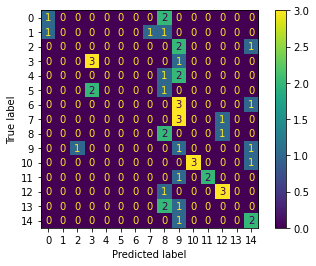

In [167]:
print("Score (original):", mlp_classifier.score(X_test, y_test))

mlp_pred= mlp_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, mlp_pred)

### Train and test on the compressed dataset

In [168]:
mlp_classifier_compressed = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1)
mlp_classifier_compressed.fit(X_train_compressed, y_train_compressed)

MLPClassifier(learning_rate_init=0.1, random_state=1)

Score (compressed): 0.8


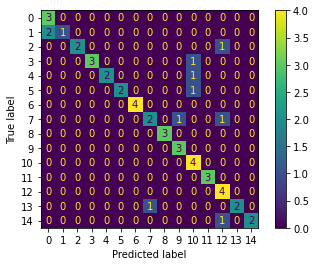

In [169]:
print("Score (compressed):", mlp_classifier_compressed.score(X_test_compressed, y_test_compressed))

mlp_pred_compressed = mlp_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, mlp_pred_compressed)

## Convolutional Neural Networks

In [11]:
from src.python.models import  Lenet5
X, y = yalefaces.load("datasets/yalefaces", flatten=False)
X = X / 255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [12]:
grid_result, cv = Lenet5().run(X_train, y_train, epochs=20, n_iter=1)

Epoch 1/10
4/4 [==============================] - 7s 2s/step - loss: 2.7339 - accuracy: 0.0174
Epoch 2/10
4/4 [==============================] - 6s 2s/step - loss: 2.7158 - accuracy: 0.0696
Epoch 3/10
4/4 [==============================] - 6s 2s/step - loss: 2.7129 - accuracy: 0.0435
Epoch 4/10
4/4 [==============================] - 6s 2s/step - loss: 2.7116 - accuracy: 0.0522
Epoch 5/10
4/4 [==============================] - 6s 2s/step - loss: 2.7122 - accuracy: 0.0435
Epoch 6/10
4/4 [==============================] - 6s 2s/step - loss: 2.7103 - accuracy: 0.0696
Epoch 7/10
4/4 [==============================] - 6s 2s/step - loss: 2.7121 - accuracy: 0.0696
Epoch 8/10
4/4 [==============================] - 6s 2s/step - loss: 2.7108 - accuracy: 0.0435
Epoch 9/10
4/4 [==============================] - 6s 2s/step - loss: 2.7118 - accuracy: 0.0522
Epoch 10/10
4/4 [==============================] - 6s 2s/step - loss: 2.7128 - accuracy: 0.0696


In [13]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.052174 using {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 10, 'model__filter_t1': 60, 'epochs': 10}
0.052174 (0.017391) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 10, 'model__filter_t1': 60, 'epochs': 10}
0.043478 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 5, 'model__filter_t1': 50, 'epochs': 10}
0.043478 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 15, 'model__filter_t1': 40, 'epochs': 10}
0.043478 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 10, 'model__filter_t1': 40, 'epochs': 10}
0.043478 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 5, 'model__filter_t1': 40, 'epochs': 10}
0.043478 (0.000000) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'adam', 'model__filter_t2': 25, 'model__filter_t1': 30, 'epochs': 10}
0.0434

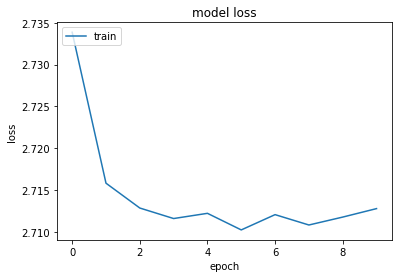

In [14]:
history = grid_result.best_estimator_.history_
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

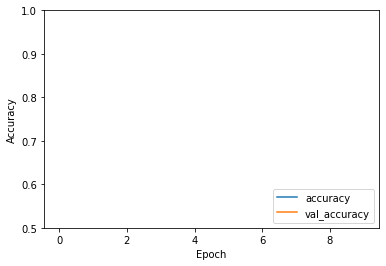

In [15]:
history = grid_result.best_estimator_.history_
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

2/2 [==============================] - 1s 166ms/step - loss: 2.7250 - accuracy: 0.0600
Score (original): [2.7249600887298584, 0.05999999865889549]
2/2 [==============================] - 1s 199ms/step


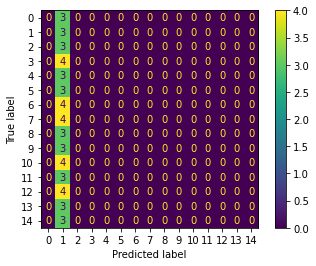

In [16]:
cls = cv.best_estimator_.model_
print("Score (original):", cls.evaluate(X_test, y_test))
y_pred = cls.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(axis=1))